In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Render plots in LaTeX
# plt.rc('text', usetex = True)
# plt.rc('font', family = 'serif')

In [3]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_10k': 'adam_lbfgs_final_10k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_10k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
metrics = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'Test L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

In [4]:
pde_name = 'reaction_diffusion' # 'wave' # 'convection'
pde_params = ['nu', '6', 'rho', '5'] # ['beta', '5'] # ['beta', '40'] 
metric = 'loss'
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_10k', 'adam_lbfgs_31k']
widths = [50, 100, 200, 400]

In [5]:
def get_best_performance(pde_name, pde_params, metric, opt, widths):
    proj_name = f'{pde_name}_{extensions[opt]}'

    # Get the best results for the corresponding metric and pde_params, making sure to separate across widths
    best_results = {}
    for width in widths:
        best_results[width] = np.inf

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue
        config = run.config
        if config['pde_params'] != pde_params:
            continue
        try:
            best_results[config['num_neurons']] = \
                np.minimum(best_results[config['num_neurons']], run.summary[metric]) \
                    if run.summary[metric] is not None else best_results[config['num_neurons']]
        except:
            print(f'Error in {run.name} in {proj_name}, run.summary[metric] = {run.summary[metric]}')

    return best_results

In [6]:
# print(get_best_performance(pde_name, pde_params, metric, 'adam', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'lbfgs', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'adam_lbfgs', widths))
# print(get_best_performance(pde_name, pde_params, metric, 'adam_lbfgs_10k', widths))

In [7]:
def get_best_performance_opts(pde_name, pde_params, metric, opts, widths):
    opt_best_results = {}
    for opt in opts:
        opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, widths)
    return opt_best_results

In [8]:
opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, widths)
# for opt in opts:
#     print(opt_best_results[opt])

In [9]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-Diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

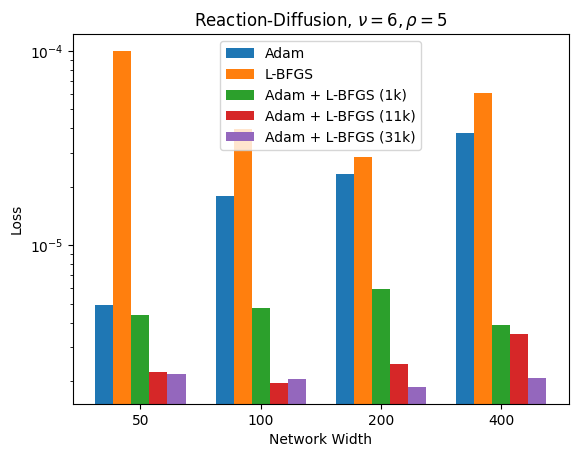

In [11]:
# Make a single bar plot of the best results, comparing across optimizers and widths
width = 0.15
fig, ax = plt.subplots()
for i, opt in enumerate(opts):
    ax.bar(np.arange(len(widths)) + i * width, [opt_best_results[opt][width] for width in widths], width, label=opt_names[opt])
ax.set_yscale('log')
ax.set_ylabel(metrics[metric])
ax.set_xlabel('Network Width')
ax.set_xticks(np.arange(len(widths)) + (len(opts) - 1) * width / 2)
ax.set_xticklabels(widths)
ax.legend()
ax.set_title(get_title(pde_name, pde_params))
plt.show()